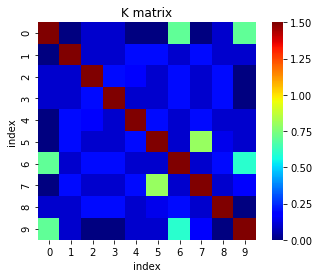

In [250]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import random
import time
from datetime import datetime

# number of landmarks to use
m = 10
# number of training data points (of 1,017,209)
n = 1000
# sigma squared parameter
sigma = 1

#kernel weights
STORE = 0.6
DATE = 0.1
DOW = 0.6
PROMO = 0.1
STATE = 0.1
SCHOOL = 0.1

data = pandas.read_csv( 'store_train.csv', low_memory=False )
data = data.sample( n=n, random_state=n )
landmarks = data.sample( n=m, random_state=m )
testd = pandas.read_csv( 'store_test.csv', low_memory=False )
N = testd.shape[0]

def store_kernel( xi, xj ):
    return int(xi == xj) * STORE
def date_kernel( xi, xj ):
    x1 = datetime.strptime(xi, '%Y-%m-%d')
    x2 = datetime.strptime(xj, '%Y-%m-%d')
    dDay = 1 - (abs(x1.day - x2.day) / 31)
    return (dDay * int(x1.month == x2.month)) * DATE
def dow_kernel( xi, xj ):
    return int(xi == xj) * DOW
def promo_kernel( xi, xj ):
    return int(xi == xj) * PROMO
def state_holiday( xi, xj ):
    return int(xi == xj) * STATE
def school_holiday( xi, xj ):
    return int(xi == xj) * SCHOOL

def kernel( xi, xj ):
    return store_kernel( xi.Store, xj.Store ) + \
            date_kernel( xi.Date, xj.Date ) + \
            dow_kernel( xi.DayOfWeek, xj.DayOfWeek )+ \
            promo_kernel( xi.Promo, xj.Promo ) + \
            state_holiday( xi.StateHoliday, xj.SchoolHoliday ) + \
            school_holiday( xi.SchoolHoliday, xj.SchoolHoliday )

def plot(matrix):
    ax = plt.subplot()
    ax = seaborn.heatmap(matrix, cmap='jet', square=True)
    ax.set_ylabel('index')
    ax.set_xlabel('index')
    ax.set_title('K matrix')
    plt.show()
    
def mew(xt, lm, cache):
    Ktm = numpy.zeros( (1, m) )
    for i in range(m):
        Ktm[0, i] = kernel(xt, lm.iloc[i])
    return numpy.dot(Ktm, cache)


# my attempt at vectorizing kernel functions

# output rows match data points, output cols match point feature importance
#def kernelMat( xi, xj ):
#    out = numpy.zeros( (xi.shape[0], xj.shape[0]) ) # xj transpose columns
#    print(xi.Store)
#    print(xj.Store)
#    out[:, 0] = numpy.where(xi.Store == xj.Store, 1, 0) # store number: store match is crucial
#    out[:, 1] = numpy.ones(N) # dow: dow is crucial
#    out[:, 2] = numpy.zeros(N) # date: no effect
#    out[:, 3] = numpy.zeros(N) # sales: no cheating
#    out[:, 4] = numpy.zeros(N) # customers: no cheating
#    out[:, 5] = numpy.ones(N) # open: crucial
#    out[:, 6] = numpy.zeros(N) # promo: no effect
#    out[:, 7] = numpy.zeros(N) # state: no effect
#    out[:, 8] = numpy.zeros(N) # school: no effect
#    out[:, 9] = numpy.zeros(N) # id: ignore here, just for dimensions sake
#    print(out)
#    return out
#            
#def mewMat(xtMat, lm, cache):
#    Ktm = kernelMat(xtMat, lm)
#    return numpy.dot(Ktm, cache)

# create and plot Kmm matrix
K = numpy.zeros( (m,m) )
for i in range(m):
    for j in range(m):
        K[i,j] = kernel( landmarks.iloc[i], landmarks.iloc[j] )
plot(K)

In [251]:
start = time.time()
Kmn = numpy.zeros( (m, n) )
for i in range(m):
    for j in range(n):
        Kmn[i, j] = kernel( landmarks.iloc[i], data.iloc[j] )

Kmm = numpy.zeros( (m, m) )
for i in range(m):
    for j in range(m):
        Kmm[i, j] = kernel( landmarks.iloc[i], landmarks.iloc[j] )

Y = numpy.zeros( (n, 1) )
for i in range(n):
    Y[i, 0] = data.iloc[i].Sales

Kx = numpy.dot(Kmn, Kmn.T)
Kinv = numpy.linalg.pinv(Kx + (numpy.power(sigma, 2) * Kmm))
cache = numpy.dot(Kinv, numpy.dot( Kmn, Y))
end = time.time()
print('cache completed in %.2f minutes' % ((end-start) / 60) )

cache completed in 0.08 minutes


In [252]:
preds = numpy.zeros(( N, 1 ))

start = time.time()
for i in range(N):
    inst = testd.iloc[i]
    if inst.DayOfWeek == 7 or inst.Open == 0:
        preds[ i, 0 ] = 0
    else:
        preds[ i, 0 ] = mew(inst, landmarks, cache)

# match shape of landmarks and test data
#if testd.shape[1] != landmarks.shape[1]:
#    landmarks = landmarks.drop(labels=['Sales', 'Customers'], axis=1)
#    landmarks['Id'] = range(0, m, 1)
#preds = mewMat(testd, landmarks, cache)

sfile = open( 'sub.csv', 'w' )
sfile.write( '"Id","Sales"\n' )
for i in range(N):
    sfile.write( '%d,%.2f\n' % ( i+1, preds[i] ) )  # add one for one-based indexing
sfile.close()
end = time.time()
print('predictions completed in %.2f minutes' % ((end-start) / 60) )

predictions completed in 2.06 minutes


In [253]:
print('Rossmann MSE: 0.36812')
print('Public ranking: 2968')

Rossmann MSE: 0.36812
Public ranking: 2968
